In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime, timedelta
import time
from dateutil.relativedelta import relativedelta
import os
from scipy.stats.stats import pearsonr 
# from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
# import code from other ipynbs 
import import_ipynb
from FI_class import Cash_bond, CDX, get_accrued_interest, get_datetime, get_month_by_freq, get_coupon_payment_dates

importing Jupyter notebook from FI_class.ipynb


#### 1. Data

##### Params 

In [3]:
##  @@ Change your params  
start_date = '2019-07-01'  
end_date = '2020-07-31'
hedge_amount = np.array([25, 25])   # in million usd 
hedge_amount *= 10**6 
hedge = np.array(['CDX HY', 'TLT'])

In [4]:
s = ''
for i in np.arange(len(hedge)):
    h = hedge[i]
    am = hedge_amount[i]
    s += (h + '=' + str(am/10**6) + 'M')
    s += ', '

fd_output = start_date + ' to ' + end_date + '   ' + s[:-2]
fn_output = fd_output
if not os.path.exists(os.path.join(os.getcwd(), fd_output)):
    os.makedirs(os.path.join(os.getcwd(), fd_output))

##### Bonds

In [5]:
# load bond info 
### data source: BBG terminal + tia package
fd_read = 'prices'

##  @@ Change your bond portfolio info csv 
fn = "bond info.csv"

cwd = os.getcwd()
path = os.path.join(cwd, fd_read , fn)

with open(path, 'r', encoding='utf-8') as f:  
    df = pd.read_csv(f, index_col=0)
    df.loc['Position'] = df.loc['Position'].astype('float') * 1000
    df.loc['coupon'] = df.loc['coupon'].astype('float') / 100
    df.loc['INT_ACC_DT'] = pd.to_datetime(df.loc['INT_ACC_DT'], dayfirst=1).astype('str')
    df.loc['FIRST_CPN_DT'] = pd.to_datetime(df.loc['FIRST_CPN_DT'], dayfirst=1).astype('str')
    df.loc['SECURITY_PRICING_DATE'] = pd.to_datetime(df.loc['SECURITY_PRICING_DATE'], dayfirst=1).astype('str')
    df.loc['maturity'] = pd.to_datetime(df.loc['maturity'], dayfirst=1).astype('str')
    df.loc['FIXED_REOFFER_PX'] = df.loc['FIXED_REOFFER_PX'].astype('float').fillna(100)
    
bond_info = df
bond_info.iloc[:, :5]

,USY8137FAQ10 Corp,USG84228EH74 Corp,XS2099273737 Corp,USG85381AE48 Corp,XS1506085114 Corp
Name,REPUBLIC OF SRI LANKA,STANDARD CHARTERED PLC,THETA CAPITAL PTE LTD,STUDIO CITY FINANCE LTD,THETA CAPITAL PTE LTD
CRNCY,USD,USD,USD,USD,USD
EXCH_CODE,LONDON,HONG KONG,SGX-ST,SGX-ST,SGX-ST
industry_sector,Government,Financial,Financial,"Consumer, Cyclical",Financial
rtg_moody,B2 *-,Ba1,B3,B1,B3
rtg_sp,B-,BB-,B-,BB-,B-
px_mid,84.7555,104.55,97.35,104.8035,86.4485
coupon,0.0635,0.06,0.08125,0.06,0.0675
INT_ACC_DT,2019-06-28,2020-06-26,2020-01-22,2020-07-15,2016-10-31
FIRST_CPN_DT,2019-12-28,2021-01-26,2020-07-22,2021-01-15,2017-04-30


In [6]:
##  @@ Change your bond portfolio price csv   
fn = 'bond price.csv'

path = os.path.join(cwd, fd_read , fn)

with open(path, 'r', encoding='utf-8') as f:  
    df = pd.read_csv(f, index_col=0)[2:]
    df.index = pd.to_datetime(df.index, dayfirst=1)

bond_prc = df

ts = pd.date_range(bond_prc.index.min(), bond_prc.index.max(), freq='B')   # only include business days 
bond_prc = bond_prc.reindex(ts).reindex(bond_info.columns, axis=1).fillna(method='ffill').astype('float')

bond_prc.fillna(method = 'bfill', inplace=True)

bond_prc = bond_prc.loc[start_date:end_date]   
bond_prc.head()

,USY8137FAQ10 Corp,USG84228EH74 Corp,XS2099273737 Corp,USG85381AE48 Corp,XS1506085114 Corp,XS1587867539 Corp,XS1642686676 Corp,USY2R40TAB40 Corp,XS2030531938 Corp,XS2106329134 Corp,...,XS2016067303 Corp,XS2098881654 Corp,XS2079668609 Corp,XS2215399317 Corp,XS1719264324 Corp,USG61759AA70 Corp,XS1981973941 Corp,XS1266590089 Corp,XS1526108235 Corp,USY267BJGT59 Corp
2019-07-01,100.357,99.865,90.991,100.477,91.648,94.661,95.875,105.462,101.1,75.993,...,101.15,100.267,103.395,99.922,102.625,100.076,98.213,97.053,80.616,100.966
2019-07-02,100.530,99.865,90.991,100.477,93.853,94.697,97.400,106.135,101.1,75.993,...,101.15,100.267,103.395,99.922,102.542,100.383,98.155,97.144,80.756,100.966
2019-07-03,100.462,99.865,90.991,100.477,94.223,94.909,98.775,106.004,101.1,75.993,...,101.15,100.267,103.395,99.922,102.542,100.228,98.165,97.164,80.471,100.966
2019-07-04,100.462,99.865,90.991,100.477,94.223,94.909,98.775,106.004,101.1,75.993,...,101.15,100.267,103.395,99.922,102.542,100.228,98.165,97.164,80.471,100.966
2019-07-05,100.744,99.865,90.991,100.477,93.852,94.939,98.775,105.338,101.1,75.993,...,101.15,100.267,103.395,99.922,102.667,99.782,98.175,97.052,80.402,100.966


In [7]:
# initialize bond objects 
Bonds = []
coupon_freq = 'semi-annual'
tag = ''
for i in range(bond_info.shape[1]):
    name, ccy, exchange, sector, moody_rating, snp_rating, _, coupon_rate, int_acc_dt, first_cpn_dt, pricing_date, _, maturity, reoffer, amount  = bond_info.iloc[:,i]
    midprice = bond_prc.iloc[:,i]
    isin = bond_info.columns[i]
    bond = Cash_bond(isin, name, ccy, exchange, sector, moody_rating, snp_rating, amount, midprice, reoffer, 
                 coupon_rate, tag, first_cpn_dt, int_acc_dt, pricing_date, maturity, coupon_freq)
    Bonds.append(bond)

##### CDX

In [8]:
with open(os.path.join(os.getcwd(), fd_read , 'cdx price.csv'), 'r') as f:
    df = pd.read_csv(f, index_col=0)[2:]
    df.index = pd.to_datetime(df.index, dayfirst=1)
    df = df.reindex(ts).fillna(method='ffill').astype('float').fillna(method='bfill')
    cdx_prc = df.loc[start_date:end_date]


with open(os.path.join(os.getcwd(), fd_read ,'cdx info.csv'), 'r') as f:
    df = pd.read_csv(f, index_col=0)
    cdx_info = df
    cdx_info.loc['SECURITY_PRICING_DATE'] = cdx_info.loc['CDS_FIRST_ACCRUAL_START_DATE']
    cdx_info.loc['coupon'] = cdx_info.loc['coupon'].astype('float')


with open(os.path.join(os.getcwd(), fd_read ,'cdx factor.csv'), 'r') as f:
    df = pd.read_csv(f, index_col=0)
    df.index = pd.to_datetime(df.index)
    cdx_factor = df.reindex(cdx_info.columns, axis=1).astype('float')

In [9]:
# initialize cdx objects 
Cdx = []
coupon_freq = 'quarter'

find_hy = np.where(hedge == 'CDX HY')[0]
find_em = np.where(hedge == 'CDX EM')[0]

cdx_hy_amount = hedge_amount[find_hy[0]] if find_hy.shape[0] > 0 else 1
cdx_em_amount = hedge_amount[find_em[0]] if find_em.shape[0] > 0 else 1 


for i in range(cdx_info.shape[1]):
    name, ccy, _, int_acc_dt, first_cpn_dt, maturity, _, isin, coupon_rate, pricing_date = cdx_info.iloc[:,i]
    midprice = cdx_prc.iloc[:,i]
    factor = cdx_factor.iloc[:,i]
    if i < 4: 
        cdx_amount = cdx_hy_amount
    elif i >= 4:
        cdx_amount = cdx_em_amount
    cdx = CDX(isin, name, ccy, cdx_amount, midprice, 
                 coupon_rate, tag, first_cpn_dt, int_acc_dt, maturity, coupon_freq, factor)    
    Cdx.append(cdx)

##### HYG

In [10]:
# short 
find = np.where(hedge == 'HYG')[0]
hyg_amount = - hedge_amount[find[0]] if find.shape[0] > 0 else 1 

fn = 'hyg price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
hyg_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
hyg_prc

2019-07-01    91.2348
2019-07-02    91.4345
2019-07-03    91.7813
2019-07-04    91.7813
2019-07-05    91.4135
               ...   
2020-07-27    93.7448
2020-07-28    93.5016
2020-07-29    94.0212
2020-07-30    94.2202
2020-07-31    94.3971
Freq: B, Name: TOT_RETURN_INDEX_GROSS_DVDS, Length: 285, dtype: float64

##### VXX

In [11]:
find = np.where(hedge == 'VXX')[0]
vxx_amount = hedge_amount[find[0]] if find.shape[0] > 0 else 1

fn = 'vxx price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
vxx_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
vxx_prc

2019-07-01    24.56
2019-07-02    23.65
2019-07-03    23.51
2019-07-04    23.51
2019-07-05    23.58
              ...  
2020-07-27    29.34
2020-07-28    29.17
2020-07-29    28.57
2020-07-30    29.20
2020-07-31    28.52
Freq: B, Name: TOT_RETURN_INDEX_GROSS_DVDS, Length: 285, dtype: float64

##### EMB

In [12]:
# short    
find = np.where(hedge == 'EMB')[0]
emb_amount = - hedge_amount[find[0]] if find.shape[0] > 0 else 1

fn = 'emb price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
emb_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
emb_prc

2019-07-01    119.7059
2019-07-02    119.9169
2019-07-03    120.2441
2019-07-04    120.2441
2019-07-05    119.6214
                ...   
2020-07-27    124.0782
2020-07-28    123.6594
2020-07-29    124.3868
2020-07-30    124.3537
2020-07-31    124.6403
Freq: B, Name: TOT_RETURN_INDEX_GROSS_DVDS, Length: 285, dtype: float64

##### TLT 

In [13]:
find = np.where(hedge == 'TLT')[0]
tlt_amount = hedge_amount[find[0]] if find.shape[0] > 0 else 1
  
fn = 'tlt price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
tlt_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
tlt_prc

2019-07-01    135.4935
2019-07-02    136.5386
2019-07-03    137.5120
2019-07-04    137.5120
2019-07-05    135.6882
                ...   
2020-07-27    176.5700
2020-07-28    177.7916
2020-07-29    177.4888
2020-07-30    178.6582
2020-07-31    178.5434
Freq: B, Name: TOT_RETURN_INDEX_GROSS_DVDS, Length: 285, dtype: float64

##### Gold ETF

In [14]:
find = np.where(hedge == 'Gold')[0]
gold_amount = hedge_amount[find[0]] if find.shape[0] > 0 else 1
 
fn = 'gold price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
gold_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
gold_prc

2019-07-01    130.62
2019-07-02    133.41
2019-07-03    133.63
2019-07-04    133.63
2019-07-05    132.14
               ...  
2020-07-27    182.23
2020-07-28    183.75
2020-07-29    185.13
2020-07-30    183.76
2020-07-31    185.43
Freq: B, Name: TOT_RETURN_INDEX_GROSS_DVDS, Length: 285, dtype: float64

##### S&P 500 Index

In [15]:
# short 
find = np.where(hedge == 'SNP')[0]
snp_amount = - hedge_amount[find[0]] if find.shape[0] > 0 else 1
 
fn = 'snp price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
snp_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
snp_prc

2019-07-01    3020.9659
2019-07-02    3029.9284
2019-07-03    3053.9054
2019-07-04    3053.9054
2019-07-05    3048.7156
                ...    
2020-07-27    3370.3347
2020-07-28    3348.5571
2020-07-29    3390.1785
2020-07-30    3377.9981
2020-07-31    3404.2739
Freq: B, Name: TOT_RETURN_INDEX_GROSS_DVDS, Length: 285, dtype: float64

##### Hang Seng Index

In [16]:
# short 
find = np.where(hedge == 'HS')[0]
hs_amount = - hedge_amount[find[0]] if find.shape[0] > 0 else 1 

fn = 'hang seng price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
hs_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
hs_prc

2019-07-01    29442.0051
2019-07-02    29902.9522
2019-07-03    29881.8057
2019-07-04    29820.3233
2019-07-05    29798.6383
                 ...    
2020-07-27    26408.5019
2020-07-28    26590.4388
2020-07-29    26708.9178
2020-07-30    26523.7071
2020-07-31    26400.0115
Freq: B, Name: TOT_RETURN_INDEX_GROSS_DVDS, Length: 285, dtype: float64

##### iTraxx Asia IG 

In [17]:
with open(os.path.join(os.getcwd(), fd_read ,'cdx info asia ig.csv'), 'r') as f:
    df = pd.read_csv(f, index_col=0)
    ig_info = df
    ig_info.loc['SECURITY_PRICING_DATE'] = ig_info.loc['CDS_FIRST_ACCRUAL_START_DATE']
    ig_info.loc['coupon'] = ig_info.loc['coupon'].astype('float')
ig_info

with open(os.path.join(os.getcwd(), fd_read , 'asia ig price.csv'), 'r') as f:
    df = pd.read_csv(f, index_col=0)
    df.index = pd.to_datetime(df.index, dayfirst=1)
    df = df.reindex(ts).fillna(method='ffill').astype('float').fillna(method='bfill')
    ig_prc = df.loc[start_date:end_date]
ig_prc


ig_factor = pd.DataFrame().reindex_like(ig_prc)
ig_factor.iloc[:, :] = 1

In [18]:
# initialize asia ig cdx objects 
IG = []
coupon_freq = 'quarter'
exchange = ''; sector=''; moody_rating=''; snp_rating=''; tag=''; 
find = np.where(hedge == 'ASIA IG')[0]
ig_amount = hedge_amount[find[0]] if find.shape[0] > 0 else 1 
 

for i in range(ig_info.shape[1]):
    name, ccy, _, int_acc_dt, first_cpn_dt, maturity, _, isin, coupon_rate, pricing_date = ig_info.iloc[:,i]
    midprice = ig_prc.iloc[:,i]
    factor = ig_factor.iloc[:,i]
    ig = CDX(isin, name, ccy, ig_amount, midprice,  coupon_rate, tag, first_cpn_dt, int_acc_dt, maturity, coupon_freq, factor)
    IG.append(ig)

##### Indonesia SR CDS

In [19]:
find = np.where(hedge == 'INDON')[0]
indon_amount = hedge_amount[find[0]] if find.shape[0] > 0 else 1 

fn = 'cds indon price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
indon_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
indon_prc

2019-07-01     99.892796
2019-07-02     99.892796
2019-07-03    100.579580
2019-07-04    100.654758
2019-07-05    100.591648
                 ...    
2020-07-27     99.169052
2020-07-28     99.198873
2020-07-29     99.167463
2020-07-30     99.163154
2020-07-31     99.281293
Freq: B, Name: Prices, Length: 285, dtype: float64

##### China SR CDS

In [20]:
find = np.where(hedge == 'CN')[0]
cn_amount = hedge_amount[find[0]] if find.shape[0] > 0 else 1

fn = 'cds china price.csv'   
with open(os.path.join(os.getcwd(), fd_read, fn), 'r') as f:
    df = pd.read_csv(f, index_col=0).iloc[:, -1]
    df.index = pd.to_datetime(df.index)
  
cn_prc = df.reindex(ts, axis=0).fillna(method='ffill').loc[start_date:end_date]
cn_prc

2019-07-01    102.703915
2019-07-02    102.759097
2019-07-03    102.750598
2019-07-04    102.779503
2019-07-05    102.788815
                 ...    
2020-07-27    102.703961
2020-07-28    102.712749
2020-07-29    102.724289
2020-07-30    102.715823
2020-07-31    102.754016
Freq: B, Name: Prices, Length: 285, dtype: float64

#### 2. Back Test

In [21]:
##  @@ Change the hedges you've been using here 
hedge_names = np.array(['CDX HY', 'CDX EM', 'HYG', 'VXX', 'EMB', 'TLT', 'Gold', 'SNP', 'HS', 'ASIA IG', 'INDON', 'CN'])

N = hedge_names.shape[0]
arr_hedge = np.zeros(N)
arr_hedge[np.isin(hedge_names, hedge)] = 1 
arr_hedge = arr_hedge[:,np.newaxis]

##### Nav and PnL

In [22]:
df_bond = pd.DataFrame(index = bond_prc.index, columns = bond_prc.columns)   # principal + accrued interest  
df_cdx = pd.DataFrame(index = bond_prc.index, columns = cdx_prc.columns)   # npv of cdx hy & cdx em 
df_ig = pd.DataFrame(index = bond_prc.index, columns = ig_prc.columns)   # npv of itraxx asia-ex japan ig 

# temp
df_coupon = pd.DataFrame().reindex_like(bond_prc)   # Cash for bond coupon payment  
df_issuance = pd.DataFrame().reindex_like(bond_prc)   # Cash for bond new issuance  
df_roll_close = pd.DataFrame().reindex_like(cdx_prc)   # Cash for cdx series rolling 
df_roll_open = pd.DataFrame().reindex_like(cdx_prc)

df_roll_close_ig = pd.DataFrame().reindex_like(ig_prc)   
df_roll_open_ig = pd.DataFrame().reindex_like(ig_prc)


######  1
for i in range(bond_info.shape[1]):
        bond = Bonds[i]
    
        ### update position if needed (for strategy) ###
       
        df_bond.iloc[:, i] = bond.dirty_price()
        df_coupon.iloc[:, i] = bond.coupon()
        df_issuance.iloc[:, i] = bond.issuance() 
    


#####  2
for i in range(cdx_info.shape[1]):
    cdx = Cdx[i]
    mask = cdx.exist()
    npv = cdx.npv()
    df_cdx.iloc[:, i] = npv * mask 
    
    df_roll_close.iloc[:, i] = cdx.roll_close()
    df_roll_open.iloc[:, i] = cdx.roll_open()
    
    
    
#####  3
for i in range(ig_info.shape[1]):
    ig = IG[i]
    mask = ig.exist()
    npv = ig.npv()
    df_ig.iloc[:, i] = npv * mask 
    
    df_roll_close_ig.iloc[:, i] = ig.roll_close()
    df_roll_open_ig.iloc[:, i] = ig.roll_open()
    

      
coupon = df_coupon.sum(axis = 1)
issuance = df_issuance.sum(axis = 1)
issuance_plus = issuance.cumsum() - issuance.cumsum()[-1]  
roll_hy = (df_roll_close + df_roll_open).iloc[:,:-4].sum(axis=1)
roll_em = (df_roll_close + df_roll_open).iloc[:,-4:].sum(axis=1)
roll_ig = (df_roll_close_ig + df_roll_open_ig).sum(axis=1)
roll_plus_hy = roll_hy.cumsum() - roll_hy.cumsum()[-1] 
roll_plus_em = roll_em.cumsum() - roll_em.cumsum()[-1]
roll_plus_ig = roll_ig.cumsum() - roll_ig.cumsum()[-1] 

   
df_bond.fillna(0, inplace = True)

df_bond.head()

,USY8137FAQ10 Corp,USG84228EH74 Corp,XS2099273737 Corp,USG85381AE48 Corp,XS1506085114 Corp,XS1587867539 Corp,XS1642686676 Corp,USY2R40TAB40 Corp,XS2030531938 Corp,XS2106329134 Corp,...,XS2016067303 Corp,XS2098881654 Corp,XS2079668609 Corp,XS2215399317 Corp,XS1719264324 Corp,USG61759AA70 Corp,XS1981973941 Corp,XS1266590089 Corp,XS1526108235 Corp,USY267BJGT59 Corp
2019-07-01,1.004099e+06,0.0,0.0,0.0,927917.5,970887.777778,1.092812e+06,1.059458e+06,0.0,0.0,...,0.0,0.0,0.0,0.0,1.033292e+06,1.020288e+06,997650.833333,993863.333333,979337.083333,0.0
2019-07-02,1.006006e+06,0.0,0.0,0.0,950155.0,971511.666667,1.108253e+06,1.066367e+06,0.0,0.0,...,0.0,0.0,0.0,0.0,1.032732e+06,1.023615e+06,997277.777778,994940.000000,980935.000000,0.0
2019-07-03,1.005502e+06,0.0,0.0,0.0,954042.5,973895.555556,1.122194e+06,1.065236e+06,0.0,0.0,...,0.0,0.0,0.0,0.0,1.033003e+06,1.022322e+06,997584.722222,995306.666667,978282.916667,0.0
2019-07-04,1.005678e+06,0.0,0.0,0.0,954230.0,974159.444444,1.122385e+06,1.065415e+06,0.0,0.0,...,0.0,0.0,0.0,0.0,1.033274e+06,1.022579e+06,997791.666667,995473.333333,978480.833333,0.0
2019-07-05,1.008675e+06,0.0,0.0,0.0,950707.5,974723.333333,1.122576e+06,1.058934e+06,0.0,0.0,...,0.0,0.0,0.0,0.0,1.034795e+06,1.018376e+06,998098.611111,994520.000000,977988.750000,0.0


In [23]:
def get_cumu_return(rtn):
    return (1+rtn).cumprod()-1

def get_pnl(nav, asset='Bond', hedge=25*10**6):

    pnl = nav - nav.shift(1)
    pnl_tot = np.nansum(pnl)
    pnl_std = np.std(pnl, ddof=1)   
    if asset in ['CDX HY', 'CDX EM', 'ASIA IG']:
        return_daily = pnl / hedge 
    elif asset in ['HYG', 'EMB', 'SNP', 'HS']:
        return_daily = -pnl / nav.shift(1)
    else:
        # bond, indon cds, cn cds 
        return_daily = pnl / nav.shift(1)
        
    return_vol = np.std(return_daily, ddof=1)  
    return_cumu = get_cumu_return(return_daily)
    
    return pnl, pnl_tot, pnl_std, return_daily, return_vol, return_cumu

In [24]:
bond_nav = df_bond.sum(axis = 1)
cdx_hy_nav = df_cdx.iloc[:, :-4].sum(axis=1)
cdx_em_nav = df_cdx.iloc[:, -4:].sum(axis=1)
ig_nav = df_ig.sum(axis=1)
hyg_nav = hyg_prc * hyg_amount / hyg_prc[0]
emb_nav = emb_prc * emb_amount / emb_prc[0]
vxx_nav = vxx_prc * vxx_amount / vxx_prc[0]
tlt_nav = tlt_prc * tlt_amount / tlt_prc[0]
gold_nav = gold_prc * gold_amount / gold_prc[0]
snp_nav = snp_prc * snp_amount / snp_prc[0]
hs_nav = hs_prc * hs_amount / hs_prc[0]
indon_nav = indon_prc * indon_amount / indon_prc[0]
cn_nav = cn_prc * cn_amount / cn_prc[0]


bond_nav_adj = bond_nav + issuance_plus + coupon
bond_pnl, bond_pnl_tot, bond_pnl_std, bond_return, bond_return_vol, bond_return_cumu = get_pnl(bond_nav_adj) 

cdx_hy_pnl, cdx_hy_pnl_tot, cdx_hy_pnl_std, cdx_hy_return, cdx_hy_return_vol, cdx_hy_return_cumu = get_pnl(cdx_hy_nav, asset='CDX HY', hedge = cdx_hy_amount)
cdx_em_pnl, cdx_em_pnl_tot, cdx_em_pnl_std, cdx_em_return, cdx_em_return_vol, cdx_em_return_cumu = get_pnl(cdx_em_nav, asset='CDX EM', hedge = cdx_em_amount)
ig_pnl, ig_pnl_tot, ig_pnl_std, ig_return, ig_return_vol, ig_return_cumu = get_pnl(ig_nav, asset='ASIA IG', hedge = ig_amount)

hyg_pnl, hyg_pnl_tot, hyg_pnl_std, hyg_return, hyg_return_vol, hyg_return_cumu = get_pnl(hyg_nav, asset='HYG', hedge = hyg_amount)
emb_pnl, emb_pnl_tot, emb_pnl_std, emb_return, emb_return_vol, emb_return_cumu = get_pnl(emb_nav, asset='EMB', hedge = emb_amount)

vxx_pnl, vxx_pnl_tot, vxx_pnl_std, vxx_return, vxx_return_vol, vxx_return_cumu = get_pnl(vxx_nav, asset='VXX', hedge = vxx_amount)
tlt_pnl, tlt_pnl_tot, tlt_pnl_std, tlt_return, tlt_return_vol, tlt_return_cumu = get_pnl(tlt_nav, asset='TLT', hedge = tlt_amount)
gold_pnl, gold_pnl_tot, gold_pnl_std, gold_return, gold_return_vol, gold_return_cumu = get_pnl(gold_nav, asset='Gold', hedge = gold_amount)
snp_pnl, snp_pnl_tot, snp_pnl_std, snp_return, snp_return_vol, snp_return_cumu = get_pnl(snp_nav, asset='SNP', hedge = snp_amount)
hs_pnl, hs_pnl_tot, hs_pnl_std, hs_return, hs_return_vol, hs_return_cumu = get_pnl(hs_nav, asset='HS', hedge = hs_amount)
indon_pnl, indon_pnl_tot, indon_pnl_std, indon_return, indon_return_vol, indon_return_cumu = get_pnl(indon_nav, asset='INDON', hedge = indon_amount)
cn_pnl, cn_pnl_tot, cn_pnl_std, cn_return, cn_return_vol, cn_return_cumu = get_pnl(cn_nav, asset='CN', hedge = cn_amount)


nav = bond_nav_adj
pnl = bond_pnl
for h in hedge:
    if h == 'CDX HY':
        # total with cdx hy 
        nav = nav + cdx_hy_nav + roll_plus_hy
        pnl = pnl + cdx_hy_pnl + roll_hy 
    elif h == 'CDX EM':
        # total with cdx em
        nav = nav + cdx_em_nav + roll_plus_em
        pnl = pnl + cdx_em_pnl + roll_em
    elif h == 'HYG':
        # total with hyg 
        nav = nav + (hyg_nav - hyg_amount)
        pnl = pnl + hyg_pnl    
    elif h == 'VXX':
        nav = nav + (vxx_nav - vxx_amount)
        pnl = pnl + vxx_pnl
    elif h == 'EMB':
        nav = nav + (emb_nav - emb_amount)
        pnl = pnl + emb_pnl
    elif h == 'TLT':
        nav = nav + (tlt_nav - tlt_amount)
        pnl = pnl + tlt_pnl
    elif h == 'Gold':
        nav = nav + (gold_nav - gold_amount)
        pnl = pnl + gold_pnl  
    elif h == 'SNP':
        nav = nav + (snp_nav - snp_amount)
        pnl = pnl + snp_pnl
    elif h == 'HS':
        nav = nav + (hs_nav - hs_amount)
        pnl = pnl + hs_pnl
    elif h == 'ASIA IG':
        nav = nav + ig_nav + roll_plus_ig
        pnl = pnl + ig_pnl + roll_ig
    elif h == 'INDON':
        nav = nav + (indon_nav - indon_amount)
        pnl = pnl + indon_pnl
    elif h == 'CN':
        nav = nav + (cn_nav - cn_amount)
        pnl = pnl + cn_pnl
    
    

pnl_tot = np.nansum(pnl)
pnl_std = np.std(pnl, ddof=1)
return_daily = pnl / nav.shift(1)
return_vol = np.std(return_daily, ddof=1)
return_cumu = get_cumu_return(return_daily)


return_diff = bond_return_cumu - return_cumu   # difference due to hedge 

##### Beta

In [25]:
hedge_nav = [cdx_hy_nav, cdx_em_nav, hyg_nav, vxx_nav, emb_nav, tlt_nav, gold_nav, snp_nav, hs_nav, ig_nav, indon_nav, cn_nav]
hedge_pnl = [cdx_hy_pnl, cdx_em_pnl, hyg_pnl, vxx_pnl, emb_pnl, tlt_pnl, gold_pnl, snp_pnl, hs_pnl, ig_pnl, indon_pnl, cn_pnl]
hedge_return = [cdx_hy_return, cdx_em_return, hyg_return, vxx_return, emb_return, tlt_return, gold_return, snp_return, hs_return,
               ig_return, indon_return, cn_return]
hedge_amt = [cdx_hy_amount, cdx_em_amount, hyg_amount, vxx_amount, emb_amount, tlt_amount, gold_amount, snp_amount, hs_amount,
            ig_amount, indon_amount, cn_amount]


hedge_nav = np.array(hedge_nav)
hedge_pnl = np.array(hedge_pnl)
hedge_return = np.array(hedge_return)
hedge_amt = np.array(hedge_amt)

In [26]:
from linear_model import LinearRegression

def get_reg(rtn1, rtn2):
    reg = LinearRegression().fit(rtn1[1:,np.newaxis], rtn2[1:,np.newaxis])
    beta = reg.coef_[0][0]
    p = reg.p[0][0]
    return beta, p 


beta, p = get_reg(bond_return, 
                  np.nansum((arr_hedge* hedge_return* hedge_amt[:,np.newaxis] ) / (arr_hedge * hedge_amt[:,np.newaxis]).sum(), axis=0))

c:\program files (x86)\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


##### Statistics (output)

In [27]:
## 1. nav output 
# Hedge Return: weighted average 
hedge_pnl_ = np.nansum(arr_hedge * hedge_pnl, axis=0)
hedge_return_ = np.nansum((arr_hedge* hedge_return* hedge_amt[:,np.newaxis] ) / (arr_hedge * hedge_amt[:,np.newaxis]).sum(), axis=0)
same_direc = (bond_return * hedge_return_ > 0)*1

res = pd.concat([bond_nav, coupon, issuance_plus, bond_nav_adj, bond_pnl, bond_return, bond_return_cumu, 
                pd.Series(np.nansum(arr_hedge* hedge_nav, axis=0), index = bond_nav.index),
                pd.Series(hedge_pnl_, index = bond_nav.index),
                pd.Series(hedge_return_, index = bond_nav.index),
                 return_daily, return_cumu, return_diff, same_direc], axis=1)

res.columns = ['Bond Nav (Net)', 'Cash for Coupon Payment', 'Cash for New Issuance', 'Bond Nav', 'Bond PnL', 'Bond Return', 'Bond Return Cumulative', 
               'Hedge Nav', 'Hedge PnL', 'Hedge Return',
              'Total Return Daily', 'Total Return Cumulative', 'Difference in Return', 'Same Direction']
res
res.to_csv(os.path.join(os.getcwd(), fd_output, fn_output+  '  nav.csv'), date_format='%Y-%m-%d', float_format='%.8f')

In [28]:
## 2. statistics output 
df_stat = pd.DataFrame(columns = ['Bond', 'Hedge', 'Total'])
hedge_return_cumu_ = (1+hedge_return_).cumprod()-1 
hedge_amt_ = np.nansum(np.squeeze(arr_hedge) * hedge_amt)   # arr_hedge shape (N_hedge, 1)
 
df_stat.loc['Total PnL'] = [bond_pnl_tot, np.sum(hedge_pnl_), pnl_tot]
df_stat.loc['Stdev(PnL)'] = [bond_pnl_std, np.std(hedge_pnl_, ddof=1), pnl_std]
df_stat.loc['Return (%)'] = [bond_return_cumu[-1], hedge_return_cumu_[-1], return_cumu[-1]]
df_stat.loc['Daily Volatility'] = [bond_return_vol, np.std(hedge_return_, ddof=1), return_vol]
df_stat.loc['Annualized Vol'] = np.sqrt(252) * df_stat.loc['Daily Volatility']
df_stat.loc[''] = [np.nan for i in range(df_stat.shape[1])]
df_stat.loc['Notional'] = [bond_nav_adj[0], hedge_amt_, bond_nav_adj[0] - hedge_amt_]
df_stat.loc['PnL / Notional'] = df_stat.loc['Total PnL'] / df_stat.loc['Notional']
df_stat.loc['Stdev / Notional'] = df_stat.loc['Stdev(PnL)'] / df_stat.loc['Notional']
df_stat.loc[' '] = df_stat.loc['']
df_stat.loc['Correlation by PnL'] = [np.nan, pearsonr(bond_pnl[1:], hedge_pnl_[1:])[0], np.nan]   # pearson coef 
df_stat.loc['Correlation by Return'] = [np.nan, pearsonr(bond_return[1:], hedge_return_[1:])[0],  np.nan]
df_stat.loc['  '] = df_stat.loc['']
df_stat.loc['Same direction'] = [np.sum(same_direc), np.nan, np.nan]
# df_stat.loc['Total Days'] = [df_bond.shape[0] - 1, '', '']
df_stat.loc['Same direction %'] = [np.sum(same_direc) / (df_bond.shape[0] - 1), np.nan, np.nan]
df_stat.loc['   '] = df_stat.loc['']
df_stat.loc['Scale of hedge notional to same as bond'] = [np.nan, np.sum(hedge_pnl_) / hedge_amt_ * bond_nav_adj[0], 
                                                           np.nan]

df_stat.loc['Beta to Bond'] = [np.nan, beta, np.nan]
df_stat.loc['P value'] = [np.nan, p, np.nan]
df_stat

df_stat.to_csv(os.path.join(os.getcwd(), fd_output, fn_output+  '  stat.csv'), float_format='%.4f')


In [29]:
## 3. split statistics by frequency  

def get_var_by_freq(ts, var='return', freq='month'):

    df = pd.DataFrame(ts[1:])
    df.columns = [var]
    if freq == 'month':
        df[freq] = df.index.astype('str').map(lambda x: ''.join(x.split('-')[:2]))
        group = df.groupby(freq)
        if var == 'return':
            df_by_freq = group.apply(lambda x: get_cumu_return(x[var])[-1])
        elif var == 'pnl':
            df_by_freq = group.apply(lambda x: np.nansum(x[var]))
        elif var == 'vol':
            # input return series !! 
            df_by_freq = group.apply(lambda x: np.sqrt(252)*np.std(x[var], ddof=1))
    return df_by_freq

def get_var_by_freq_2(ts1, ts2, var='corr', freq='month'):
    df = pd.concat([ts1[1:], ts2[1:]], axis=1)
    df.columns = ['1', '2']
    if freq == 'month':
        df[freq] = df.index.astype('str').map(lambda x: ''.join(x.split('-')[:2]))
        group = df.groupby(freq)
        if var == 'corr':
            df_by_freq = group.apply(lambda x: pearsonr(x['1'], x['2'])[0])
        elif var == 'direc':
            df_by_freq = group.apply(lambda x: np.sum( (x['1']*x['2']>0) * 1 ) / x['1'].shape[0] )
    return df_by_freq
    

# freq = 'month'
bond_return_monthly = get_var_by_freq(bond_return)
hedge_return_monthly = get_var_by_freq(pd.Series(hedge_return_, index = bond_nav.index))
return_monthly = get_var_by_freq(return_daily)

bond_pnl_monthly = get_var_by_freq(bond_pnl, 'pnl')
hedge_pnl_monthly = get_var_by_freq(pd.Series(hedge_pnl_, index = bond_nav.index), 'pnl')
pnl_monthly = get_var_by_freq(pnl, 'pnl')

# vol uses return series
bond_vol_monthly = get_var_by_freq(bond_return, 'vol')
hedge_vol_monthly = get_var_by_freq(pd.Series(hedge_return_, index = bond_nav.index), 'vol')  
vol_monthly = get_var_by_freq(return_daily, 'vol')

bond_hedge_corr_monthly = get_var_by_freq_2(bond_return, pd.Series(hedge_return_, index = bond_nav.index), 'corr')
bond_total_corr_monthly = get_var_by_freq_2(bond_return, return_daily, 'corr')

bond_hedge_same_direc_monthly = get_var_by_freq_2(bond_return, pd.Series(hedge_return_, index = bond_nav.index), 'direc')
bond_total_same_direc_monthly = get_var_by_freq_2(bond_return, return_daily, 'direc')


summ = pd.DataFrame(columns = bond_return_monthly.index)
summ.loc['Bond Return'] = bond_return_monthly
summ.loc['Hedge Return'] = hedge_return_monthly
summ.loc['Total Return'] = return_monthly

summ.loc['Bond PnL'] = bond_pnl_monthly
summ.loc['Hedge PnL'] = hedge_pnl_monthly
summ.loc['Total PnL'] = pnl_monthly

summ.loc['Bond Annual Vol'] = bond_vol_monthly
summ.loc['Hedge Annual Vol'] = hedge_vol_monthly
summ.loc['Total Annual Vol'] = vol_monthly

summ.loc['Bond-Hedge Correlation'] = bond_hedge_corr_monthly
summ.loc['Bond-Total Correlation'] = bond_total_corr_monthly

summ.loc['Bond-Hedge Same Direction %'] = bond_hedge_same_direc_monthly
summ.loc['Bond-Total Same Direction %'] = bond_total_same_direc_monthly

summ

summ.to_csv(os.path.join(os.getcwd(), fd_output, fn_output+ '  stats by month.csv'), float_format='%.4f')

#### Plot 

##### Nav plot

<Figure size 432x288 with 0 Axes>

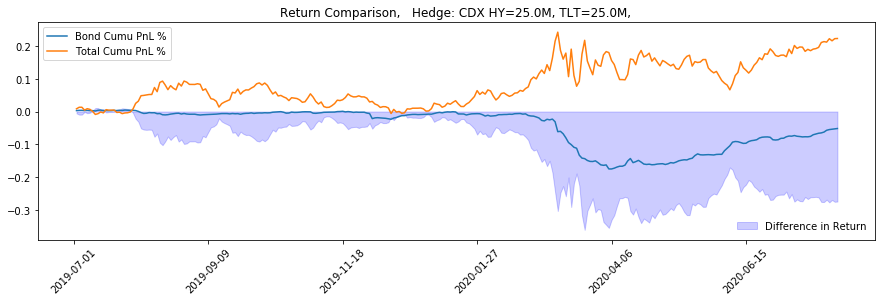

In [30]:
plt.clf()

df_rtn_cp = pd.DataFrame(index = df_bond.index.astype('str'))
df_rtn_cp['Bond Cumu PnL %'] = bond_return_cumu
df_rtn_cp['Total Cumu PnL %'] = return_cumu
df_rtn_cp['Diff'] = return_diff


plots = []
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
df_rtn_cp[['Bond Cumu PnL %', 'Total Cumu PnL %']].plot(ax=ax)
ax.legend(loc='best')
shade = plt.fill_between(df_rtn_cp.index, return_diff, 0,
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2)          # Transparency of the fill
ax.set_title('Return Comparison' + ',   Hedge: ' + s)
plt.xticks(rotation=45)

from matplotlib.legend import Legend
leg = Legend(ax, [shade], ['Difference in Return'],
             loc='lower right', frameon=False)
ax.add_artist(leg)

fig.savefig(os.path.join(os.getcwd(), fd_output, fn_output + '  performance.jpg'), bbox_inches='tight')

##### Histogram plot

C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 432x288 with 0 Axes>

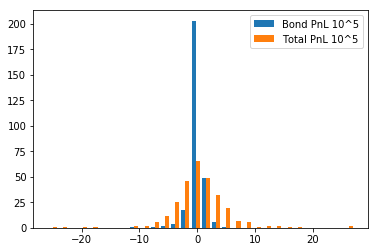

Bond PnL:
Mean= -6238.163145539876    Skewness= -2.593470803068819    Kurtosis= 16.588691953942185
Bond+Hedge PnL:
Mean= 25348.03624355516    Skewness= 0.16225923436772216    Kurtosis= 7.8781031062102524


In [31]:
# histograms
plt.clf()

f = plt.figure()
plt.hist([bond_pnl/10**5, pnl/10**5], bins=30, label = ['Bond PnL 10^5', 'Total PnL 10^5'])
plt.legend(loc='upper right')
plt.show()

print("Bond PnL:")
print("Mean=", bond_pnl.mean(), "   Skewness=", bond_pnl.skew(), "   Kurtosis=", bond_pnl.kurtosis())   # excess kurtosis over gaussian dist = 3
print("Bond+Hedge PnL:")
print("Mean=", pnl.mean(), "   Skewness=", pnl.skew(), "   Kurtosis=", pnl.kurtosis())

f.savefig(os.path.join(os.getcwd(), fd_output, fn_output+ '  hist.jpg'), bbox_inches='tight')
